# Clustering chemicals based on their descriptors

The scripts bellow use K-Means clustering the classify the merged FEMA-JECFA chemicals based on the merged descriptors obtained in [fema_jecfa_merge](fema_jecfa_merge.ipynb) and reduced in the [rdkit_chemical_matching](rdkit_chemical_matching.ipynb) notebook.

In [1]:
import os.path as path
import pickle

# Load merged FEMA-JECFA database
BASE_DATA_PATH = path.join(path.expanduser('~'),
                           'Dropbox',
                           'bymt',
                           'data_dumps',
                           'chem_project')

paired_chemicals_path = path.join(BASE_DATA_PATH,
                                  'rdkit_chemical_matching',
                                  'trimmed_rdkit_chemicals.pkl')
with open(paired_chemicals_path, 'rb') as f:
    paired_chemicals = pickle.load(f)
    
DATA_PATH = path.join(BASE_DATA_PATH, 'descriptor_clustering')

Add unique id numbers to the chemicals in merged list so that I can relate their classification back to their chemical

In [2]:
from copy import deepcopy

def add_id(dicto_list):
    """
    Add unique id numbers to the dictos in dicto_list.
    Each id is the index of that dicto in the list.
    """
    new_list = deepcopy(dicto_list)
    for i, dicto in enumerate(new_list):
        dicto['id'] = i
    return new_list

In [3]:
id_chemicals = add_id(paired_chemicals)
print(id_chemicals[0]['id'])

0


Create list of tuples pairing chemical id with its merged descriptors as input for K-means clustering

In [4]:
def id_descriptor_lists(dicto_list):
    """
    Creates paired lists. One with ids, the other with merged descriptors
    """
    ids, descriptors = [], []
    for dicto in dicto_list:
        ids.append(dicto['id'])
        descriptors.append(dicto['merged descriptors'])
    return ids, descriptors

In [5]:
ids, descriptors = id_descriptor_lists(id_chemicals)
print('lengths make sense: {}' .format(len(descriptors)==len(id_chemicals)))

lengths make sense: True


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.75, 
                             stop_words='english',
                             norm='l2',
                             ngram_range=(1,1))

descriptor_vector = vectorizer.fit_transform(descriptors)
print(descriptor_vector.shape)

(2170, 671)


In [7]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

def apply_lsa(X, n_components):

    print('Performing dimensionality reduction using LSA')
    # Since SVD results are not normalized, we have to redo the normalization.
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(norm = 'l2', copy=False)
    lsa = make_pipeline(svd, normalizer)

    X_trans = lsa.fit_transform(X)

    explained_variance = svd.explained_variance_ratio_.sum()
    print('Explained variance of the SVD step: {}%'
          .format(int(explained_variance * 100)))
    
    return X_trans

In [8]:
X = apply_lsa(descriptor_vector, 230)

Performing dimensionality reduction using LSA
Explained variance of the SVD step: 90%


In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def make_silhouettes(X, range_n_clusters, random_state):

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)

        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])

        # Clustering happens here
        clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
        cluster_labels = clusterer.fit_predict(X)


        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

For n_clusters = 2 The average silhouette_score is : 0.0314374137438


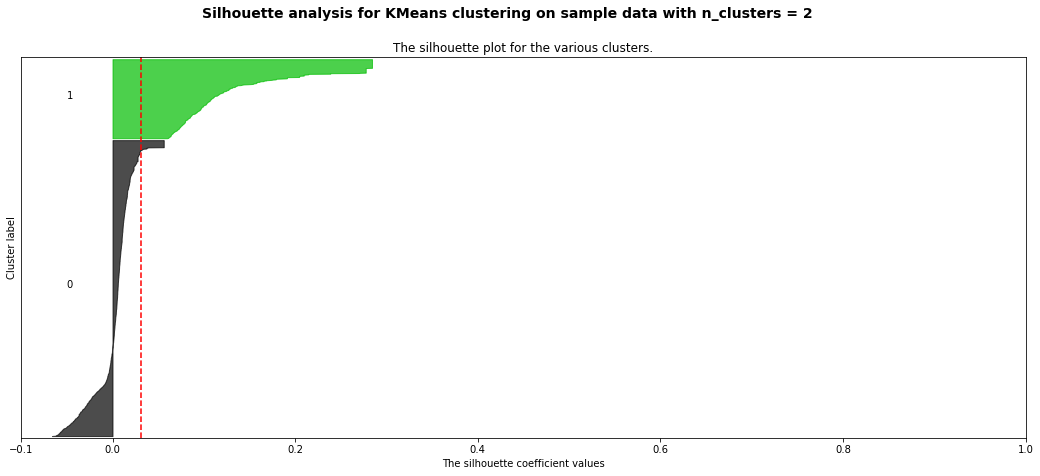

For n_clusters = 3 The average silhouette_score is : 0.0471706211731


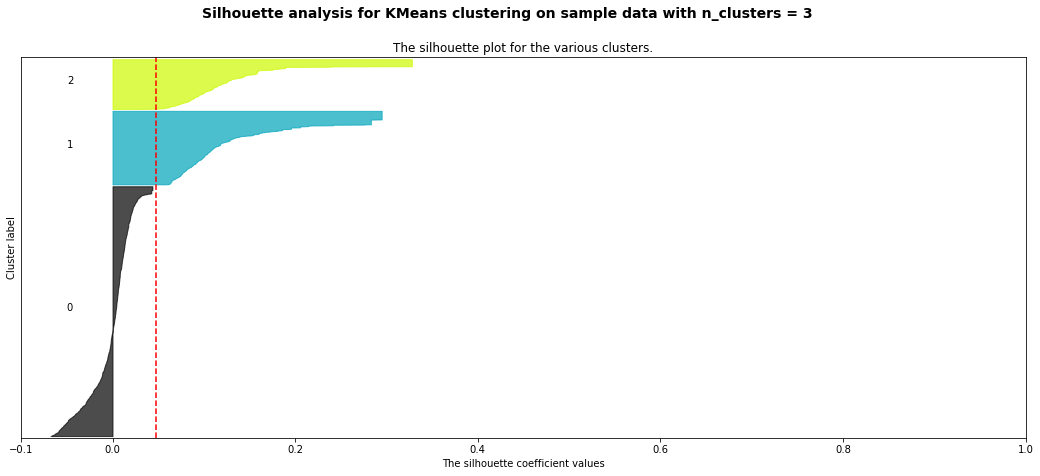

In [10]:
make_silhouettes(X, [2, 3], 10)

Visualize the clusters using wordclouds

In [12]:
from wordcloud import WordCloud
import warnings

def kmeans_wordcloud(n_clusters, descriptors, rows, columns,
                     random_state=42, figsize=(10,5)):
    """
    MISSING DOCS
    """
    
    #Don't display tight-layout warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
    
    assert n_clusters <= rows*columns, "Not enough rows and columns"
    clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = clusterer.fit_predict(X)
    descriptors = np.array(descriptors)
    plt.close('all')
    fig, axs = plt.subplots(rows, columns, squeeze=False)
    fig.set_tight_layout(True)
    fig.set_size_inches(figsize[0], figsize[1])
    axs = axs.flatten()
    
    for label in range(rows*columns):
        ca = axs[label]
        ca.set_axis_off()
        
        #Try loop becuase there might be more subplots than actual clusters
        try:
            #generate text
            idxs = cluster_labels == label
            text_array = descriptors[idxs]
            text = ''
            for string in text_array:
                text += ' '
                text += string

            # Generate a word cloud image
            wordcloud = WordCloud().generate(text)

            # Display the generated image:
            
            ca.imshow(wordcloud, interpolation='bilinear')
            ca.set_title('Wordcloud for label {}' .format(label))
        except:
             pass
            
    plt.show()
    return cluster_labels

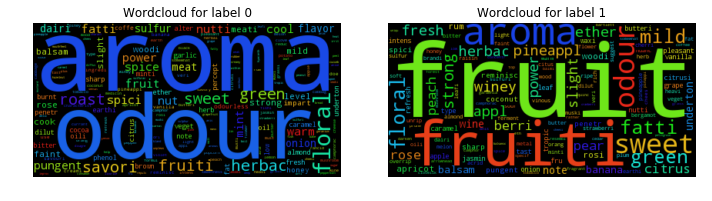

In [13]:
labels_2 = kmeans_wordcloud(2, descriptors, 1, 2)

"aroma" and "odour" descriptors are unnecessary and overwhelming the clustering. Will remove from descriptors used to cluster.

In [14]:
import re

def descriptor_cleanup(dicto_list):
    """
    Removes 'aroma' and 'odour' from merged descriptors. Also removes duplicates.
    """
    new_list = deepcopy(dicto_list)
    
    for dicto in new_list:
        descriptors = dicto.get('merged descriptors')
        descriptors.strip()
#         print(descriptors)
        assert descriptors != None, "Dicto_list has a dicto without merged descriptors"
        to_remove = ['aroma', 'odour', 'like', 'at']
        for string in to_remove:
            descriptors = descriptors.replace(string, '')
        #remove 'fruiti', but only if 'fruit' is present
        fruiti = re.compile(r'\bfruiti\b')
        fruit = re.compile(r'\bfruit\b')
        if re.search(fruit, descriptors):
            descriptors = re.sub(fruiti, '', descriptors)
        descriptors = descriptors.split(' ')
        descriptors = list(set(descriptors))
        base = ''
        for string in descriptors:
            base += ' '
            base += string
        dicto['merged descriptors'] = base.strip()
#         print(dicto.get('merged descriptors'))
    return new_list

In [15]:
cleaned_chemicals = descriptor_cleanup(id_chemicals)

Dump cleaned chemicals

In [15]:
cleaned_chemicals_path = path.join(DATA_PATH, 'cleaned_chemicals.pkl')

with open(cleaned_chemicals_path, 'wb') as f:
    pickle.dump(cleaned_chemicals, f, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
ids, descriptors = id_descriptor_lists(cleaned_chemicals)
print('lengths make sense: {}' .format(len(descriptors)==len(id_chemicals)))
vectorizer = TfidfVectorizer(max_df=0.75, 
                             stop_words='english',
                             norm='l2',
                             ngram_range=(1,1))

descriptor_vector = vectorizer.fit_transform(descriptors)
print(descriptor_vector.shape)

lengths make sense: True
(2170, 660)


In [17]:
X = apply_lsa(descriptor_vector, 330)

Performing dimensionality reduction using LSA
Explained variance of the SVD step: 95%


For n_clusters = 2 The average silhouette_score is : 0.0381817340794


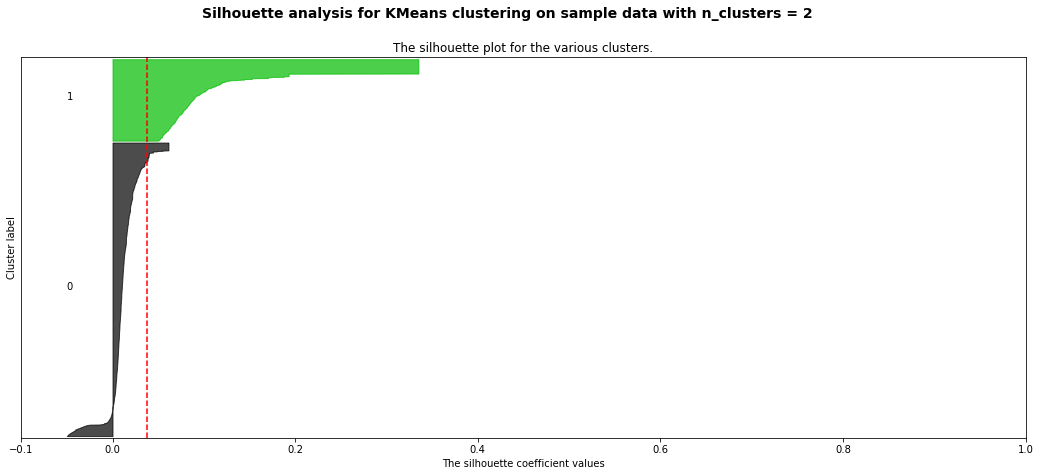

For n_clusters = 3 The average silhouette_score is : 0.0528594623626


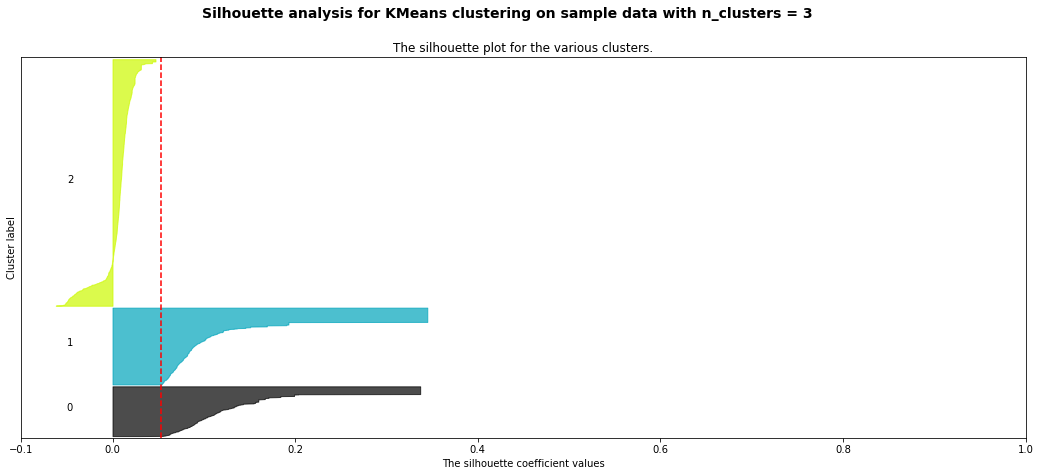

In [18]:
make_silhouettes(X, [2,3], 42)

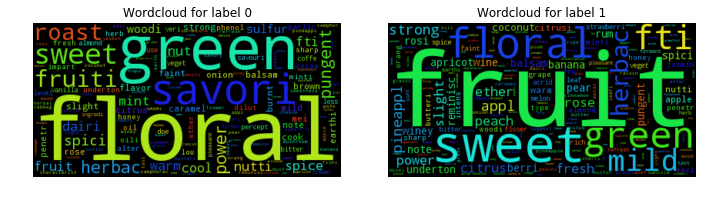

In [20]:
labels_2  = kmeans_wordcloud(2, descriptors, 1, 2)

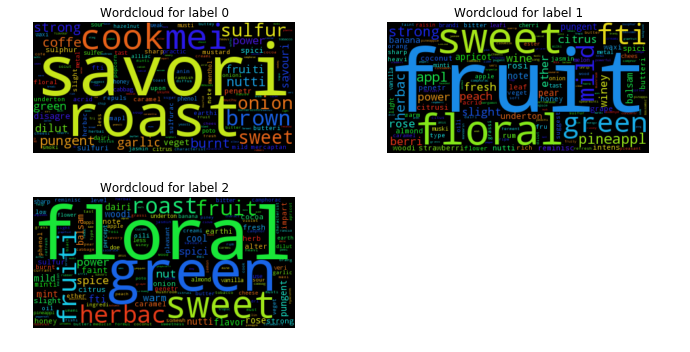

In [19]:
labels_3 = kmeans_wordcloud(3, descriptors, 2, 2)

In [21]:
for label in [0,1,2]:
    print('Label {} cluster size: {}' .format(label, len(np.where(labels_3==label)[0])))

Label 0 cluster size: 290
Label 1 cluster size: 447
Label 2 cluster size: 1433


The labels from the 3-cluster clustering make the most intuitive sense:
- Cluster 0 has 290 chemicals and is characterized by savory, roast, and brown notes
- Cluster 1 has 447 chemicals and is characterized by Fruity and sweet notes
- Cluster 2 has 1433 chemicals and is characterized by floral and green notes

Clusters 0 and 1 have clearly defined silhouettes. Cluster 2 is not as clear, probably because it is the largest as well as fairly similar to cluster 1. 

Because I want to focus on meaty savory chemicals I will merge clusters 1 and 2 together, and keep cluster 0 as its own. 

In [25]:
labels_3[labels_3==0] = 4
labels_3[labels_3==1] = 0
labels_3[labels_3==2] = 0
labels_3[labels_3==4] = 1

In [27]:
def labels_wordcloud(cluster_labels, descriptors, rows, columns,
                     random_state=42, figsize=(10,5)):
    """
    MISSING DOCS
    """
    
    #Don't display tight-layout warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
    descriptors = np.array(descriptors)
    plt.close('all')
    fig, axs = plt.subplots(rows, columns, squeeze=False)
    fig.set_tight_layout(True)
    fig.set_size_inches(figsize[0], figsize[1])
    axs = axs.flatten()
    
    for label in range(rows*columns):
        ca = axs[label]
        ca.set_axis_off()
        
        #Try loop becuase there might be more subplots than actual clusters
        try:
            #generate text
            idxs = cluster_labels == label
            text_array = descriptors[idxs]
            text = ''
            for string in text_array:
                text += ' '
                text += string

            # Generate a word cloud image
            wordcloud = WordCloud().generate(text)

            # Display the generated image:
            
            ca.imshow(wordcloud, interpolation='bilinear')
            ca.set_title('Wordcloud for label {}' .format(label))
        except:
             pass
            
    plt.show()

In [26]:
for label in [0,1]:
    print('Label {} cluster size: {}' .format(label, len(np.where(labels_3==label)[0])))

Label 0 cluster size: 1880
Label 1 cluster size: 290


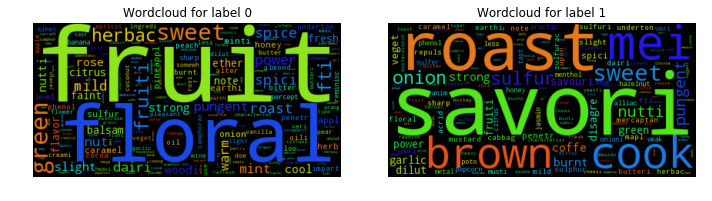

In [28]:
labels_wordcloud(labels_3, descriptors, 1, 2)

In [29]:
print('ids and labels can be zipped: {}' .format(len(ids) == len(labels_3)))
ids_labels_3 = list(zip(ids, labels_3))

ids and labels can be zipped: True


In [30]:
def label_adder(dicto_list, ids_labels):
    """
    """
    new_list = deepcopy(dicto_list)
    for i, dicto in enumerate(new_list):
        assert dicto['id'] == ids_labels[i][0], 'id and index do not match up'
        dicto['label'] = ids_labels[i][1]
    return new_list

In [31]:
labeled_chemicals = label_adder(cleaned_chemicals, ids_labels_3)
print('Lengths make sense: {}' .format(len(cleaned_chemicals)==len(labeled_chemicals)))

Lengths make sense: True


In [32]:
labeled_chemicals_path = path.join(DATA_PATH, 'labeled_chemicals_2.pkl')

with open(labeled_chemicals_path, 'wb') as f:
    pickle.dump(labeled_chemicals, f, protocol=pickle.HIGHEST_PROTOCOL)